In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import schist as scs
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_table("Seq-Well_Gierahn_Supplementary_Table_4.txt", sep=' ')

In [3]:
adata = ad.AnnData(df.T)

In [4]:
adata.obs['Exposure'] = pd.Categorical(['TBI' in x for x in adata.obs_names])

In [5]:
adata.obs['Exposure'].cat.rename_categories(['Unexposed', 'Exposed'], inplace=True)

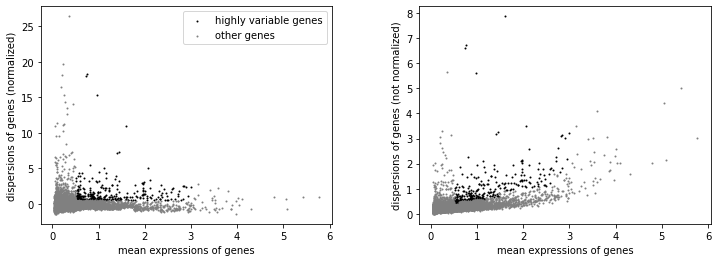

In [6]:
sc.pp.highly_variable_genes(adata, min_disp=0.5, min_mean=0.5)
sc.pl.highly_variable_genes(adata)

In [7]:
adata.var['highly_variable'].sum()

337

In [8]:
sc.tl.pca(adata, use_highly_variable=True)
n_neighbors = int(np.sqrt(adata.shape[0])/2)

/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
sc.set_figure_params(dpi_save=300)

sc.settings.verbosity=2

In [49]:
sc.pp.neighbors(adata, n_pcs=5, key_added='paper_neighbors')
sc.pp.neighbors(adata, n_neighbors=5)

computing neighbors
    using 'X_pca' with n_pcs = 5
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


In [50]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:10)


In [51]:
sc.tl.leiden(adata, resolution=0.25, key_added='paper_leiden', neighbors_key='paper_neighbors')

running Leiden clustering
    finished (0:00:00)


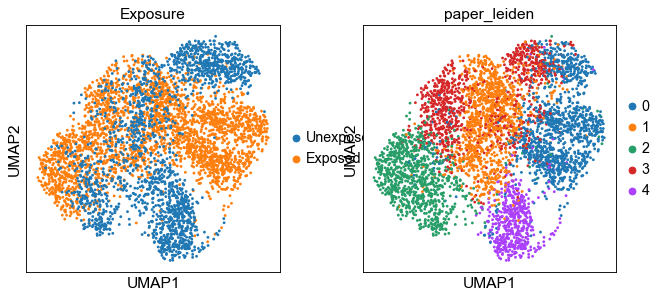

In [52]:
sc.pl.umap(adata, color=['Exposure', 'paper_leiden'])

In [53]:
sc.tl.rank_genes_groups(adata, groupby='paper_leiden')

ranking genes
    finished (0:00:02)


In [54]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head()

,0,1,2,3,4
0,MT-RNR2,ACTG1,PTAFR,CRABP2,MTRNR2L8
1,MTRNR2L2,CSF1,CD44,COX5B,FABP5
2,MTRNR2L12,RGCC,SAT1,CD52,RPS27
3,MT-RNR1,TNFSF14,SOD2,LGALS3,MTSS1L
4,MT-CO1,DUSP2,IFNGR1,SH3BGRL3,MTRNR2L1


In [57]:
scs.io.write(adata, 'seqwell_preprocess')

In [58]:
scs.inference.leiden(adata)

running Leiden clustering
    finished (0:00:34)


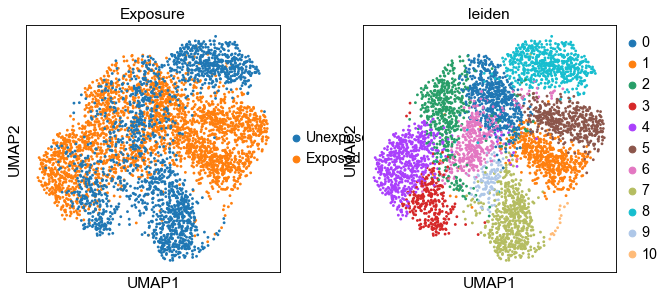

In [59]:
sc.pl.umap(adata, color=['Exposure', 'leiden'])

In [60]:
scs.inference.nested_model(adata)

minimizing the nested Stochastic Block Model
        minimization step done (0:07:26)
        consensus step done (0:07:43)
    done (0:07:43)
    finished (0:07:44)


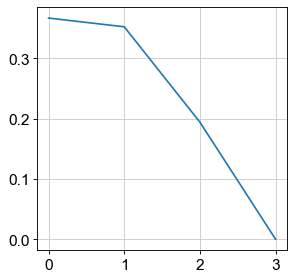

In [61]:
plot(adata.uns['schist']['stats']['modularity'])

In [62]:
level = np.argmax(adata.uns['schist']['stats']['modularity'])

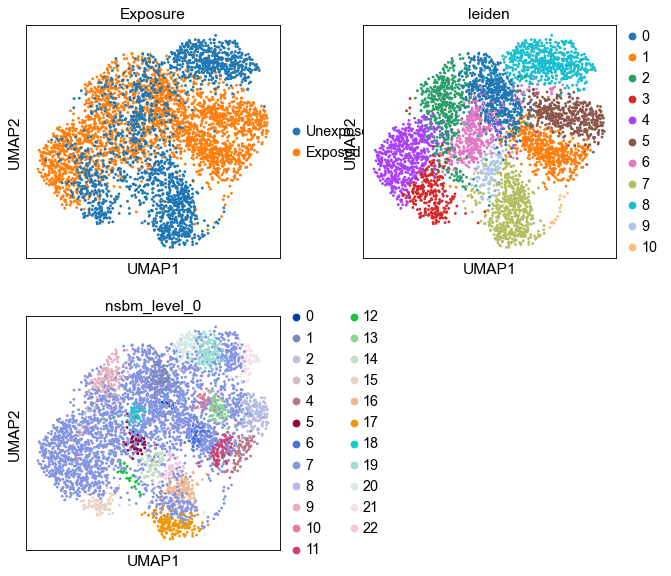

In [63]:
sc.pl.umap(adata, color=['Exposure', 'leiden', f'nsbm_level_{level}'],
          ncols=2)

In [64]:
scs.io.write(adata, "seqwell")

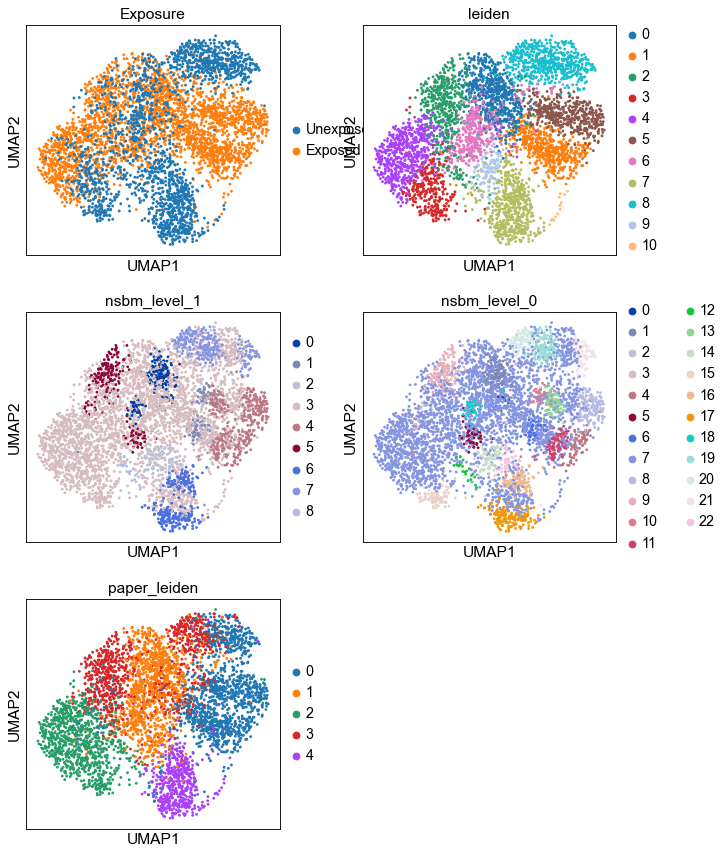

In [75]:
sc.pl.umap(adata, color=['Exposure', 'leiden', 'nsbm_level_1', 'nsbm_level_0','paper_leiden'],
          ncols=2)

In [66]:
import sklearn.metrics

In [67]:
sklearn.metrics.adjusted_rand_score(adata.obs['Exposure'], adata.obs['nsbm_level_1'])

0.06575919031956741

In [68]:
sklearn.metrics.adjusted_rand_score(adata.obs['Exposure'], adata.obs['leiden'])

0.11643451588755739

In [69]:
sklearn.metrics.adjusted_rand_score(adata.obs['Exposure'], adata.obs['nsbm_level_2'])

0.20603013074836699

In [70]:
sklearn.metrics.homogeneity_score(adata.obs['Exposure'], adata.obs['leiden'])

0.4848030494925617

In [71]:
sklearn.metrics.homogeneity_score(adata.obs['Exposure'], adata.obs['nsbm_level_2'])

0.19314120018563888

In [72]:
sklearn.metrics.homogeneity_score(adata.obs['Exposure'], adata.obs['nsbm_level_1'])

0.26836908270217

In [73]:
for cl in ['leiden', 'nsbm_level_1', 'nsbm_level_2']:
    r = sklearn.metrics.adjusted_rand_score(adata.obs['Exposure'], adata.obs[cl])
    h = sklearn.metrics.homogeneity_score(adata.obs['Exposure'], adata.obs[cl])
    c = sklearn.metrics.completeness_score(adata.obs['Exposure'], adata.obs[cl])
    print(cl, r, h, c)

leiden 0.11643451588755739 0.4848030494925617 0.14572403754214946
nsbm_level_1 0.06575919031956741 0.26836908270217 0.13841581367349567
nsbm_level_2 0.20603013074836699 0.19314120018563888 0.30686927411439746


In [74]:
for cl in ['leiden', 'nsbm_level_1', 'nsbm_level_2']:
    r = sklearn.metrics.adjusted_rand_score(adata.obs['paper_leiden'], adata.obs[cl])
    h = sklearn.metrics.homogeneity_score(adata.obs['paper_leiden'], adata.obs[cl])
    c = sklearn.metrics.completeness_score(adata.obs['paper_leiden'], adata.obs[cl])
    print(cl, r, h, c)

leiden 0.3817861938579891 0.6237906083068279 0.43557084754076053
nsbm_level_1 0.07845993565000581 0.2681550938608115 0.3212871825030798
nsbm_level_2 0.0491945572518783 0.061803676661291086 0.22811135934036575


In [76]:
scs.inference.planted_model(adata)

minimizing the Planted Partition Block Model
        minimization step done (0:04:03)
        consensus step done (0:04:06)
    done (0:04:06)
    finished (0:04:06)


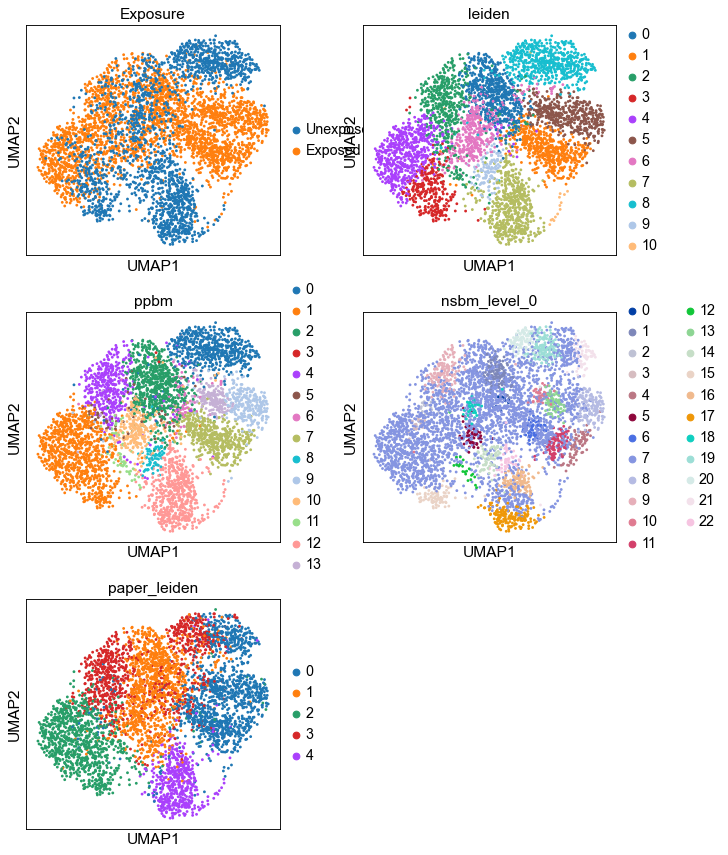

In [77]:
sc.pl.umap(adata, color=['Exposure', 'leiden', 'ppbm', 'nsbm_level_0','paper_leiden'],
          ncols=2)